# 02: Assignment_PatrickRodriguez


"You must submit a GeoJSON file of your dataset, along with a proposed related dataset, via Github, along with a proposed workflow for relating the two (expressed as a diagram). Upload the file in the Assignments folder along with a markdown document with a link to the other dataset and the proposed methodology. Ideally the related dataset will be something you have access to, but if not, describe how you would propose creating it. Come prepared to discuss, we will talk through a couple of examples next clas".

******Markdown Summary is titled "02_A_ReadMe_PatrickRodriguez.md"******


## Import libraries


In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard._map import Map
from lonboard._layer import PolygonLayer
from lonboard.colormap import apply_categorical_cmap

Now we can run the function to set the default settings for this notebook.

## Import datasets

In [6]:
import geopandas as gpd

# Load your walking route GeoJSON into a GeoDataFrame
route_gdf = gpd.read_file("02_A_Map.geojson")

# Check if it loaded correctly
print(route_gdf.head())
print(route_gdf.crs)  # Should be something like EPSG:4326 (WGS84)


                                            geometry
0  LINESTRING (-73.9565 40.80396, -73.95732 40.80...
EPSG:4326


Plotting route to check if it is working

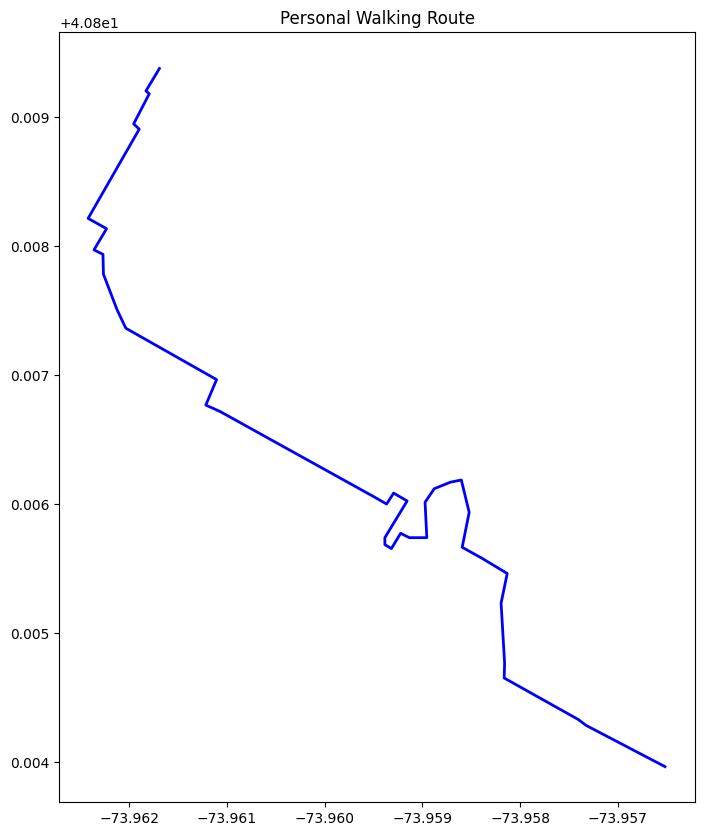

In [7]:
import matplotlib.pyplot as plt

# Basic plot of your walking route
route_gdf.plot(figsize=(10, 10), color='blue', linewidth=2)
plt.title("Personal Walking Route")
plt.show()


Setting a CRS of epsg=4326 just in case it is missing

In [4]:
# If CRS is missing, set it
if route_gdf.crs is None:
    route_gdf.set_crs(epsg=4326, inplace=True)


Loading in csv and converting it to a usable geojson.

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Load the CSV file (efficiently, with memory in mind)
# If it's huge, you can also try `chunksize=` but we'll assume it's manageable here
nypd_df = pd.read_csv("02_nypd.csv")

# Step 2: Filter to only include incidents in MANHATTAN
manhattan_df = nypd_df[nypd_df["BORO_NM"] == "MANHATTAN"]

# Optional: Drop rows with missing or invalid coordinates
manhattan_df = manhattan_df.dropna(subset=["Latitude", "Longitude"])

# Step 3: Convert to GeoDataFrame using Shapely Point geometry
geometry = [Point(xy) for xy in zip(manhattan_df["Longitude"], manhattan_df["Latitude"])]
manhattan_gdf = gpd.GeoDataFrame(manhattan_df, geometry=geometry)

# Step 4: Set coordinate reference system to WGS84 (GeoJSON standard)
manhattan_gdf.set_crs(epsg=4326, inplace=True)

# Step 5: Save to GeoJSON (for reuse in future notebooks or geojson.io)
manhattan_gdf.to_file("02_B_ManhattanCrime.geojson", driver="GeoJSON")

print("✅ Export complete: 02_B_ManhattanCrime.geojson")


C:\Users\drmim\AppData\Local\Temp\ipykernel_44184\2693399477.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  nypd_df = pd.read_csv("02_nypd.csv")


✅ Export complete: 02_B_ManhattanCrime.geojson


Visualizing the nypd map and personal route layered together. 
*Takes roughly 4 minutes to load!


C:\Users\drmim\AppData\Local\Temp\ipykernel_44184\2371215230.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  within_buffer = crime_gdf[crime_gdf.geometry.within(buffered_route.unary_union)]


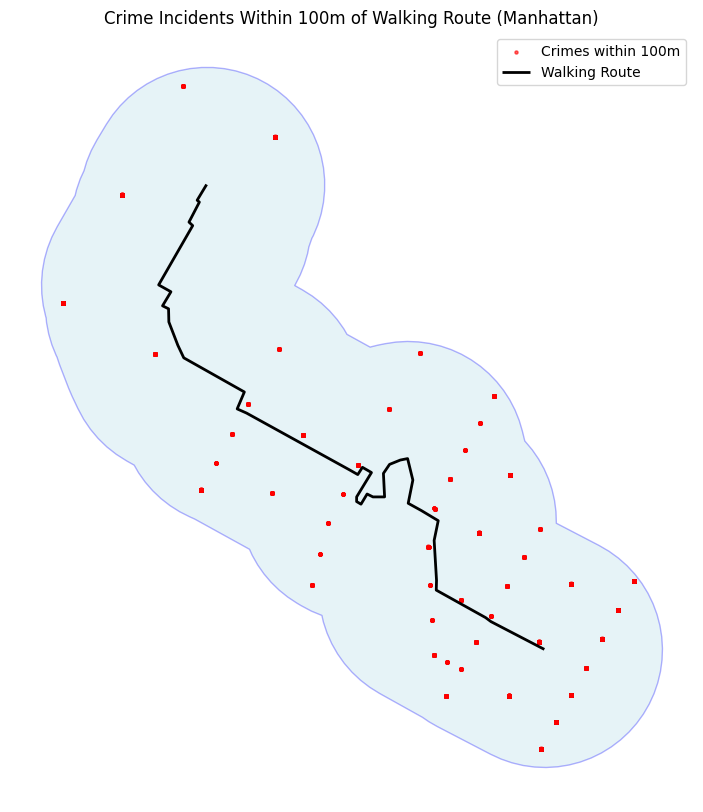

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Load both GeoJSON files
route_gdf = gpd.read_file("02_A_Map.geojson")
crime_gdf = gpd.read_file("02_B_ManhattanCrime.geojson")

# Step 2: Ensure both have the same CRS
route_gdf = route_gdf.to_crs(epsg=2263)  # NY State Plane (meters, for accurate buffering)
crime_gdf = crime_gdf.to_crs(epsg=2263)

# Step 3: Create a buffer (e.g., 100 meters around your path)
buffered_route = route_gdf.buffer(500)  # You can adjust this radius

# Step 4: Filter crime points that fall within the buffer
# `unary_union` merges all route geometries into one, if there are multiple
within_buffer = crime_gdf[crime_gdf.geometry.within(buffered_route.unary_union)]

# Step 5: Plot the result
fig, ax = plt.subplots(figsize=(10, 10))

# Plot base route buffer
gpd.GeoSeries(buffered_route).plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='blue', linewidth=1)

# Plot filtered crime points
within_buffer.plot(ax=ax, markersize=5, color='red', alpha=0.6, label="Crimes within 100m")

# Optionally plot route on top
route_gdf.plot(ax=ax, color='black', linewidth=2, label="Walking Route")

plt.title("Crime Incidents Within 100m of Walking Route (Manhattan)")
plt.legend()
plt.axis('off')
plt.show()


since it is hard to tell what is going on without context i will add a 3rd map.

In [17]:
pip install contextily



   -------------------- ------------------- 2/4 [geopy]
   ---------------------------------------- 4/4 [contextily]

Note: you may need to restart the kernel to use updated packages.


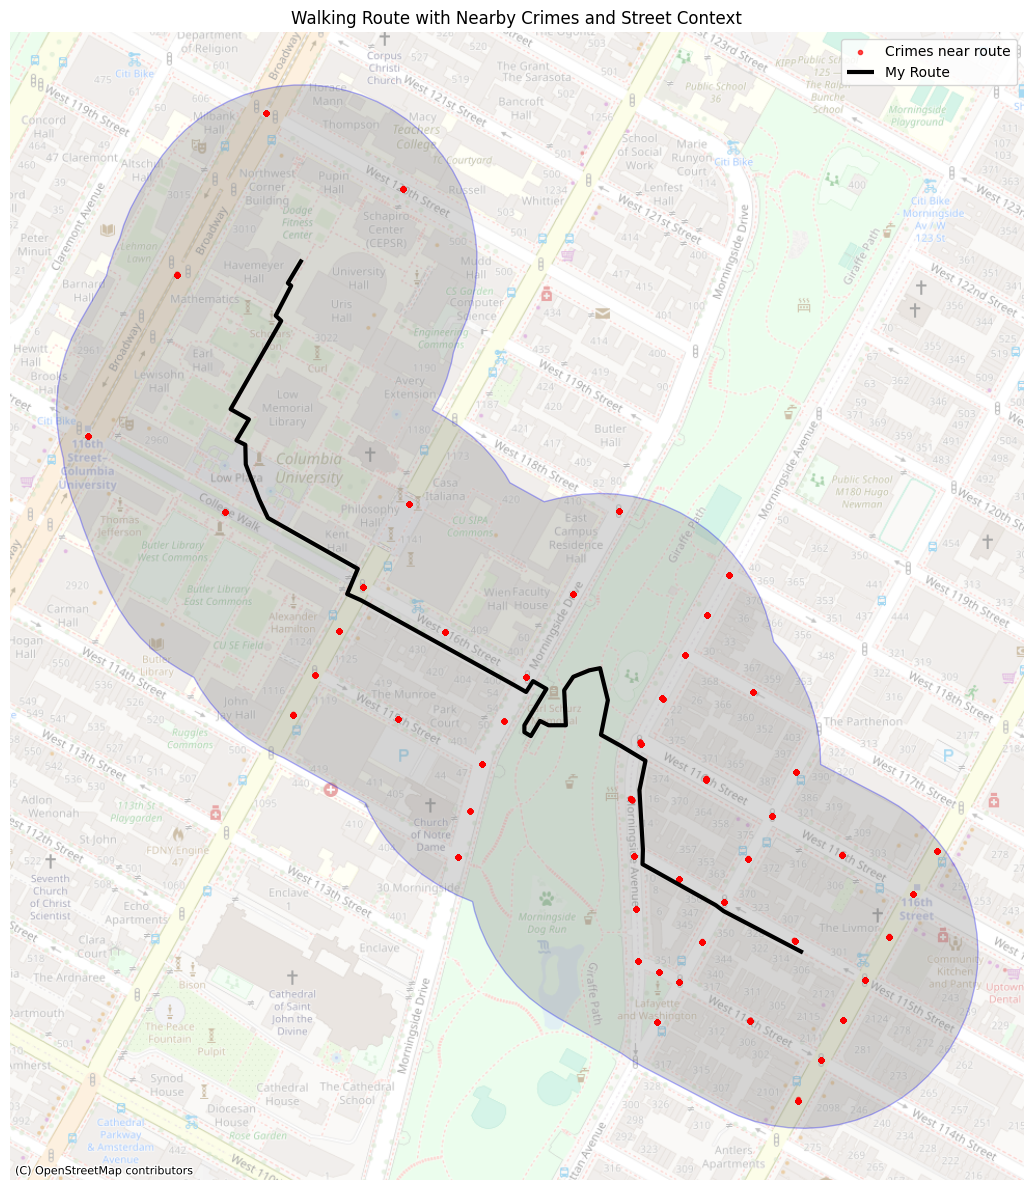

In [27]:
import contextily as ctx

# Project everything to Web Mercator for tile basemaps (EPSG:3857)
route_gdf = route_gdf.to_crs(epsg=3857)
within_buffer = within_buffer.to_crs(epsg=3857)
buffered_route = buffered_route.to_crs(epsg=3857)

# Plot with basemap
fig, ax = plt.subplots(figsize=(12, 12))

# Context: buffer zone
gpd.GeoSeries(buffered_route).plot(ax=ax, color="#818181", alpha=0.3, edgecolor='blue', linewidth=1)

# Crimes
within_buffer.plot(ax=ax, color='red', markersize=9, alpha=0.7, label="Crimes near route")

# Route
route_gdf.plot(ax=ax, color='black', linewidth=3, label="My Route")

# ✅ Add basemap with transparency here
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    alpha=0.35  # Adjust this value: 0 = fully transparent, 1 = fully opaque
)

plt.title("Walking Route with Nearby Crimes and Street Context")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


Combined map should be shown. 

It appears that there are either no crimes reported in MorningSide Park or the nypd data set does not include information within public parks. 

This could be a potential flaw in accurately representing crime complaint locations.

Regardless, I don't think i will be changing my route since the crime complaint data base shows that there have been crimes in a mostly even spread. There is no "safer" route. Safety is a constantly evolving metric and when a crime happens it is often hard to predict and mostly at random since there are many factors that are hard to consider besides repeated locations of crimes. 

If i were to continue improving this project I would make it interactable so that when you hover over the crime locations it would reveal when it occured or they would be in a gradient of colors to showcase from most to least recent crimes.